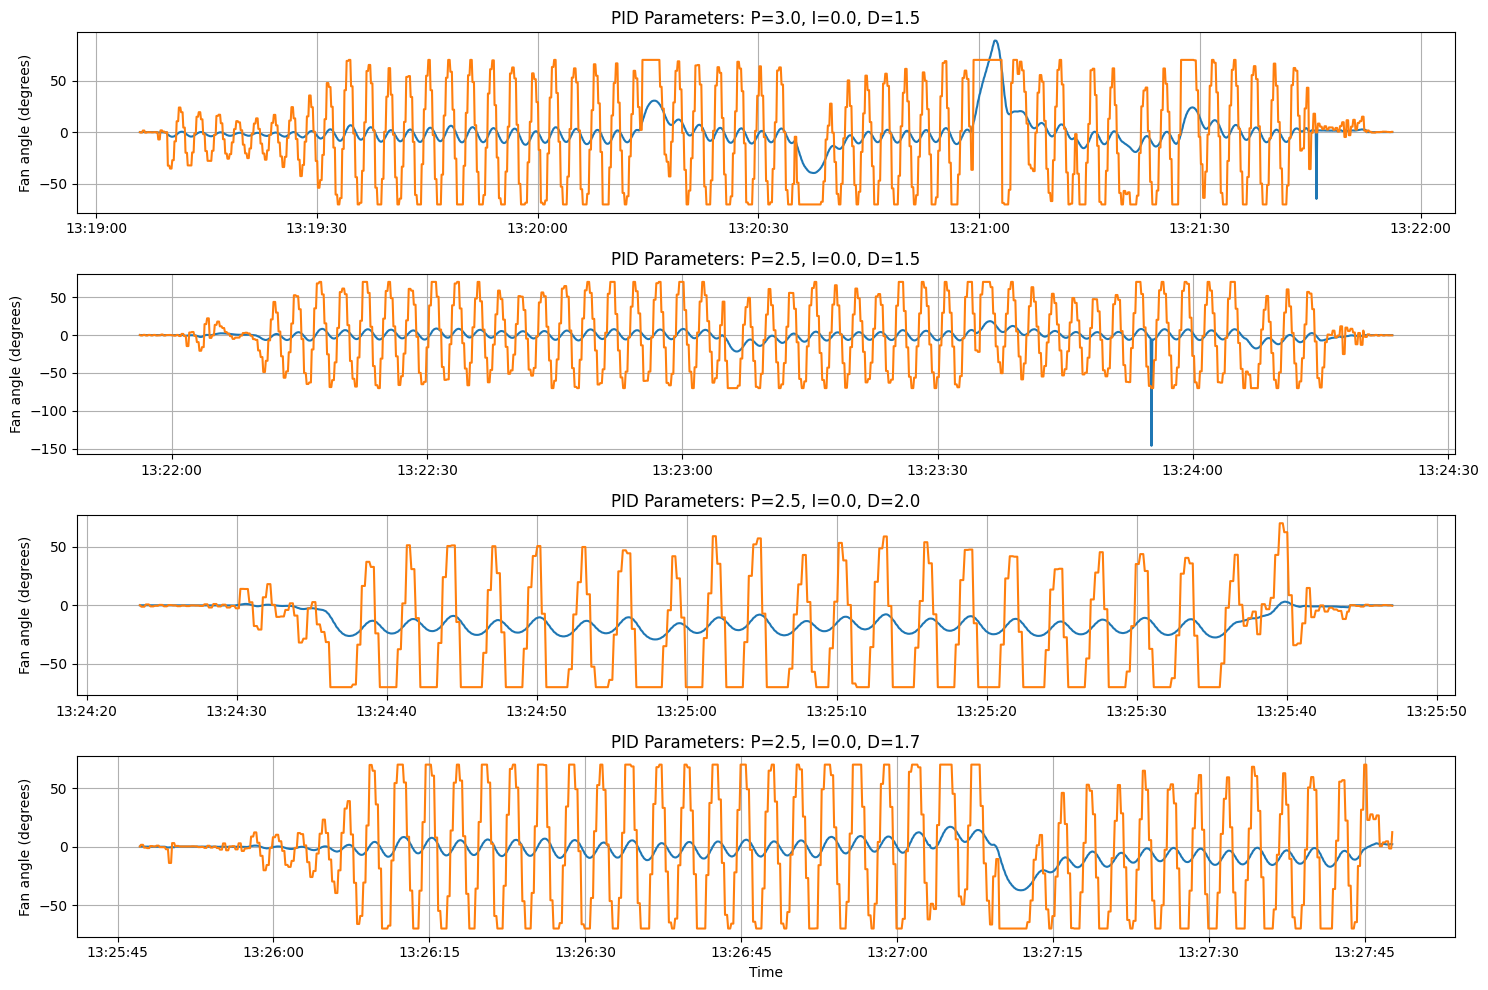

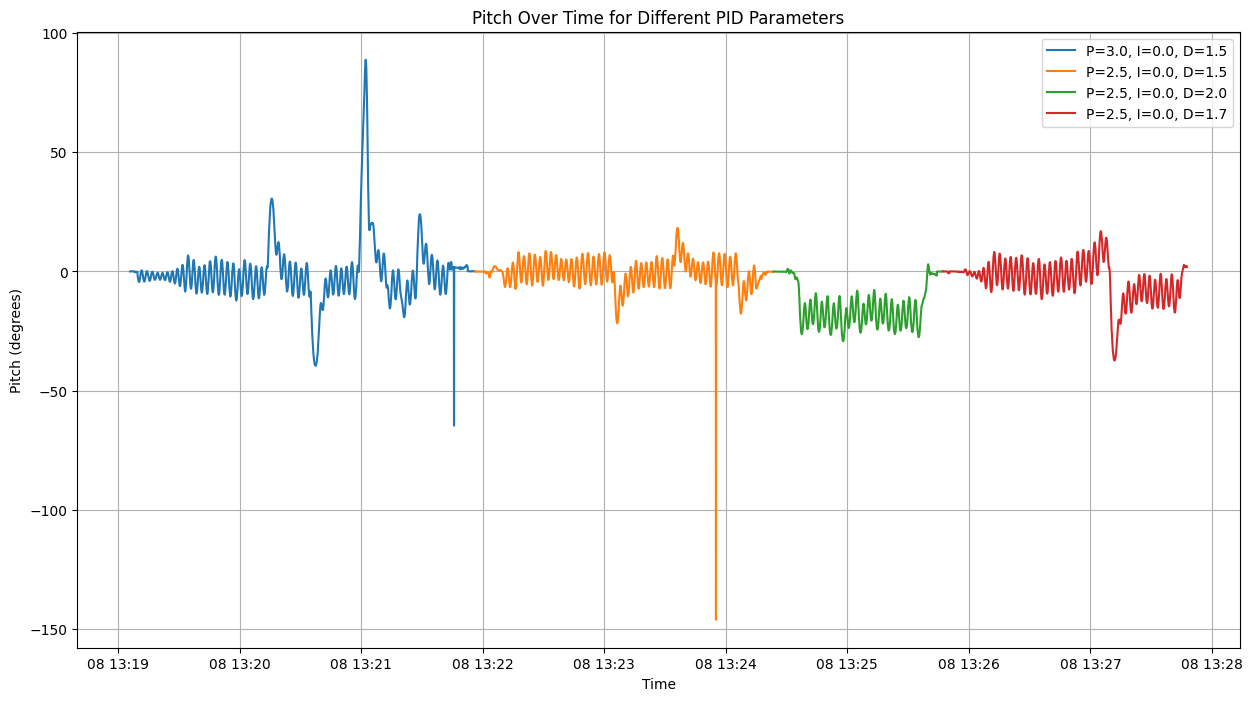


PID Performance Comparison:
P          I          D          Mean       Std Dev    Max        Min       
3.00       0.00       1.50       -0.57      13.50      88.75      -64.65    
2.50       0.00       1.50       -0.60      6.64       18.24      -146.02   
2.50       0.00       2.00       -13.87     8.89       2.98       -29.23    
2.50       0.00       1.70       -3.56      8.33       16.88      -37.33    


In [ ]:
'''
Script authored by Ben Pink to read data from 
model rocket's MPU6050 and plot its pitch and 
angle of PID controlled fan. This file was 
purposed specifically for the top-heavy 
arrangement of the model rocket.
'''

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from datetime import datetime

def parse_log_file(filename):
    """Parse the log file and extract pitch values with their PID parameters"""
    data = []
    with open(filename, 'r') as file:
        for line in file:
            if "Pitch" in line:
                try:
                    # Extract pitch value
                    pitch_part = line.split('Pitch = ')[1].split(' Fan angle = ')[0]
                    pitch = float(pitch_part)

                    # Extract Fan angle
                    fan_angle_part = line.split('Fan angle = ')[1].split(' P = ')[0]
                    fan_angle = float(fan_angle_part)
                    
                    # Extract PID parameters
                    parts = line.split('P = ')[1].split(' I = ')
                    p = float(parts[0])
                    
                    parts = line.split('I = ')[1].split(' D = ')
                    i = float(parts[0])
                    
                    parts = line.split('D = ')[1].split(" ")
                    d = float(parts[0])
                    
                    data.append({
                        'timestamp': datetime.now(),  # Placeholder - actual logs may have timestamps
                        'pitch': pitch,
                        'fan_angle': fan_angle,
                        'P': p,
                        'I': i,
                        'D': d,
                    })
                except (IndexError, ValueError) as e:
                    print(f"Error parsing line: {line.strip()}. Error: {e}")
    return data

def plot_pid_comparisons(data):
    """Plot pitch over time for different PID parameter combinations"""
    # Group data by PID parameters
    pid_groups = defaultdict(list)
    for entry in data:
        key = (entry['P'], entry['I'], entry['D'])
        pid_groups[key].append(entry)

    
    # Create a figure with subplots for each PID combination
    plt.figure(figsize=(15, 10))
    
    # Plot each PID group
    for i, (pid_params, group_data) in enumerate(pid_groups.items()):
        p, i_val, d = pid_params
        timestamps = [x['timestamp'] for x in group_data]
        pitches = [x['pitch'] for x in group_data]
        
        # Create subplot for this PID combination
        plt.subplot(len(pid_groups), 1, i+1)
        plt.plot(timestamps, pitches, label=f'P={p}, I={i_val}, D={d}')
        plt.title(f'PID Parameters: P={p}, I={i_val}, D={d}')
        plt.ylabel('Pitch (degrees)')
        plt.grid(True)
        
        # Mark when PID parameters change
        for j in range(1, len(group_data)):
            if (group_data[j]['P'], group_data[j]['I'], group_data[j]['D']) != \
               (group_data[j-1]['P'], group_data[j-1]['I'], group_data[j-1]['D']):
                plt.axvline(x=group_data[j]['timestamp'], color='r', linestyle='--', alpha=0.5)

        ################## ^ pitch ^ ############# v fan angle v #################

        fan_angles = [x['fan_angle'] for x in group_data]

        plt.subplot(len(pid_groups), 1, i+1)
        plt.plot(timestamps, fan_angles, label=f'P={p}, I={i_val}, D={d}')
        plt.title(f'PID Parameters: P={p}, I={i_val}, D={d}')
        plt.ylabel('Fan angle (degrees)')
        plt.grid(True)
        
        # Mark when PID parameters change
        for j in range(1, len(group_data)):
            if (group_data[j]['P'], group_data[j]['I'], group_data[j]['D']) != \
               (group_data[j-1]['P'], group_data[j-1]['I'], group_data[j-1]['D']):
                plt.axvline(x=group_data[j]['timestamp'], color='r', linestyle='--', alpha=0.5)
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
    
    # Also create a combined plot for comparison
    plt.figure(figsize=(15, 8))
    for pid_params, group_data in pid_groups.items():
        p, i_val, d = pid_params
        timestamps = [x['timestamp'] for x in group_data]
        pitches = [x['pitch'] for x in group_data]
        plt.plot(timestamps, pitches, label=f'P={p}, I={i_val}, D={d}')
    
    plt.title('Pitch Over Time for Different PID Parameters')
    plt.ylabel('Pitch (degrees)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_pid_performance(data):
    """Calculate performance metrics for each PID parameter set"""
    pid_stats = {}
    
    # Group data by PID parameters
    pid_groups = defaultdict(list)
    for entry in data:
        key = (entry['P'], entry['I'], entry['D'])
        pid_groups[key].append(entry)
    
    # Calculate statistics for each group
    for pid_params, group_data in pid_groups.items():
        pitches = np.array([x['pitch'] for x in group_data])
        
        pid_stats[pid_params] = {
            'mean_pitch': np.mean(pitches),
            'std_dev': np.std(pitches),
            'max_pitch': np.max(pitches),
            'min_pitch': np.min(pitches),
            'settling_time': len(group_data),  # Simplified - would need timestamps for real settling time
            'overshoot': np.max(np.abs(pitches))  # Simplified overshoot calculation
        }
    
    # Print performance comparison
    print("\nPID Performance Comparison:")
    print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "P", "I", "D", "Mean", "Std Dev", "Max", "Min"))
    
    for params, stats in pid_stats.items():
        p, i, d = params
        print("{:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format(
            p, i, d, 
            stats['mean_pitch'], 
            stats['std_dev'], 
            stats['max_pitch'], 
            stats['min_pitch']))

def main():
    # Parse the log file
    log_data = parse_log_file('C:/Users/benjp/Downloads/DATALOG_Top_2.TXT')
    
    if not log_data:
        print("No valid data found in the log file.")
        return
    
    # Assign sequential timestamps since the log doesn't have real timestamps
    start_time = datetime.now()
    for i, entry in enumerate(log_data):
        entry['timestamp'] = start_time + timedelta(seconds=i*0.1)  # Assuming 0.1s between samples
    
    # Plot the comparisons
    plot_pid_comparisons(log_data)
    
    # Analyze performance
    analyze_pid_performance(log_data)

if __name__ == "__main__":
    from datetime import timedelta
    main()